# Build a image classifier Classify and detect pictures
from a Concrete surface sample images for Surface Crack Detection dataset

 https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

This Notebook is built on the base of Coding-3-Week-2 CNNImageClassifier Notebook.

And on the process of building modle ,I referred to a tutorial notebook that uses the Dataframe method to load large amounts of data.

https://www.kaggle.com/code/gcdatkin/concrete-crack-image-detection/notebook


  ## Qixuan Xu

  MSC Creative Cumpting 

  Student ID : 20030010

---








### Import Libraries


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

### Import Dataset  from  my Google.Colab Drive

**I pre-loaded the data into Google Drive**

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
!ls "/content/drive/MyDrive/concretedataset"

Negative  Positive


In [106]:
positive_dir = Path('/content/drive/MyDrive/concretedataset/Positive')
# negative_dir = Path('../input/surface-crack-detection/Negative')
negative_dir = Path('/content/drive/MyDrive/concretedataset/Negative')
all_dir = Path('/content/drive/MyDrive/concretedataset')

### Cteate Images Dataframe 
**（refered to the tutorial notebook）**

In [5]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [7]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,/content/drive/MyDrive/concretedataset/Negativ...,NEGATIVE
1,/content/drive/MyDrive/concretedataset/Negativ...,NEGATIVE
2,/content/drive/MyDrive/concretedataset/Positiv...,POSITIVE
3,/content/drive/MyDrive/concretedataset/Positiv...,POSITIVE
4,/content/drive/MyDrive/concretedataset/Negativ...,NEGATIVE
...,...,...
40223,/content/drive/MyDrive/concretedataset/Positiv...,POSITIVE
40224,/content/drive/MyDrive/concretedataset/Negativ...,NEGATIVE
40225,/content/drive/MyDrive/concretedataset/Positiv...,POSITIVE
40226,/content/drive/MyDrive/concretedataset/Positiv...,POSITIVE


In [12]:
train_df, test_df = train_test_split(
    all_df.sample(3000, random_state=1),
    train_size=0.6,# 0.7
    shuffle=True,
    random_state=1
)

### Loading Images by Dataframe 
**（refered to the tutorial notebook）**


In [18]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255 # RGB image data
) 

# Solve memory problems for training large data sets

In [19]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 1440 validated image filenames belonging to 2 classes.
Found 360 validated image filenames belonging to 2 classes.
Found 1200 validated image filenames belonging to 2 classes.


### Create the neural network
**(By changing the week-2 Notebook)**

In [33]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

### Compile and train the model
**(By changing the week-2 Notebook)**

In [34]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 32)               0   

In [36]:
history = model.fit(train_data,
                    epochs=10, 
                    validation_data=val_data,
                    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
                    )

Epoch 1/10
45/45 [==============================] - 440s 10s/step - loss: 0.6899 - accuracy: 0.5250 - val_loss: 0.6847 - val_accuracy: 0.4917
Epoch 2/10
45/45 [==============================] - 6s 145ms/step - loss: 0.6757 - accuracy: 0.5736 - val_loss: 0.6524 - val_accuracy: 0.8194
Epoch 3/10
45/45 [==============================] - 5s 110ms/step - loss: 0.6373 - accuracy: 0.6833 - val_loss: 0.6156 - val_accuracy: 0.8111
Epoch 4/10
45/45 [==============================] - 5s 110ms/step - loss: 0.6067 - accuracy: 0.7347 - val_loss: 0.5887 - val_accuracy: 0.7028
Epoch 5/10
45/45 [==============================] - 5s 107ms/step - loss: 0.5619 - accuracy: 0.7646 - val_loss: 0.5390 - val_accuracy: 0.8222
Epoch 6/10
45/45 [==============================] - 5s 106ms/step - loss: 0.5449 - accuracy: 0.7847 - val_loss: 0.5171 - val_accuracy: 0.8556
Epoch 7/10
45/45 [==============================] - 5s 106ms/step - loss: 0.4935 - accuracy: 0.8250 - val_loss: 0.4846 - val_accuracy: 0.8889
Epoch 

## Result

### Plot how accuracy changes over time on the training set and the test ("validation") set
**(By changing the week-2 Notebook)**

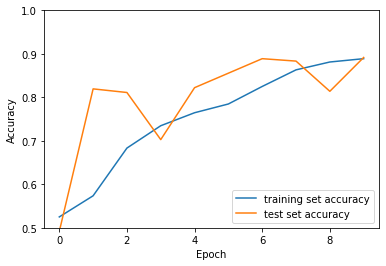

In [37]:
plt.plot(history.history['accuracy'], label='training set accuracy')
plt.plot(history.history['val_accuracy'], label = 'test set accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### Use code to test a trained model
**(By changing the week-2 Notebook)**

In [38]:
test_loss, test_acc = model.evaluate(train_data, verbose=2)
print("Test accuracy after final epoch is ", test_acc*100)

45/45 - 3s - loss: 0.3590 - accuracy: 0.9111 - 3s/epoch - 74ms/step
Test accuracy after final epoch is  91.11111164093018


### Evaluate modle 
**（refered to the tutorial notebook）**

In [66]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.35784
Test Accuracy: 90.67%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


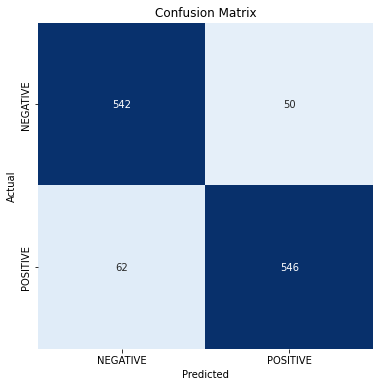

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.90      0.92      0.91       592
    POSITIVE       0.92      0.90      0.91       608

    accuracy                           0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.91      1200



In [67]:
evaluate_model(model, test_data)